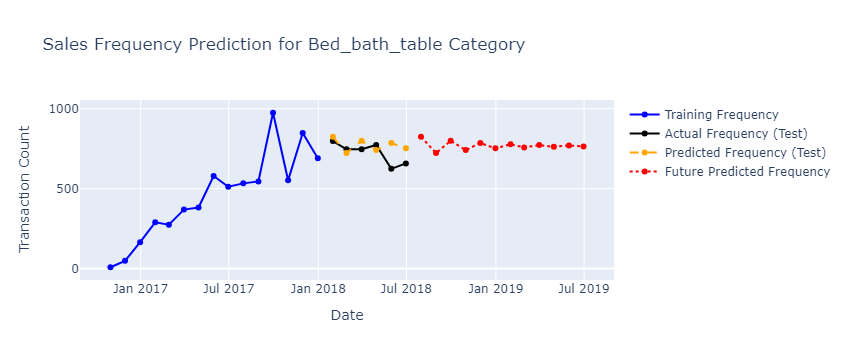

C:\Users\s\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



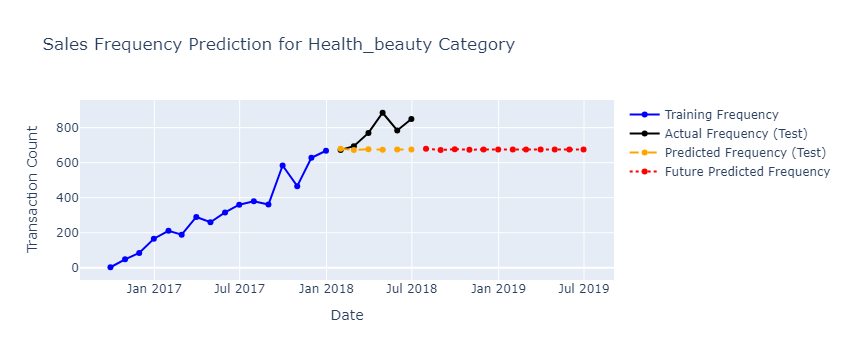

C:\Users\s\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



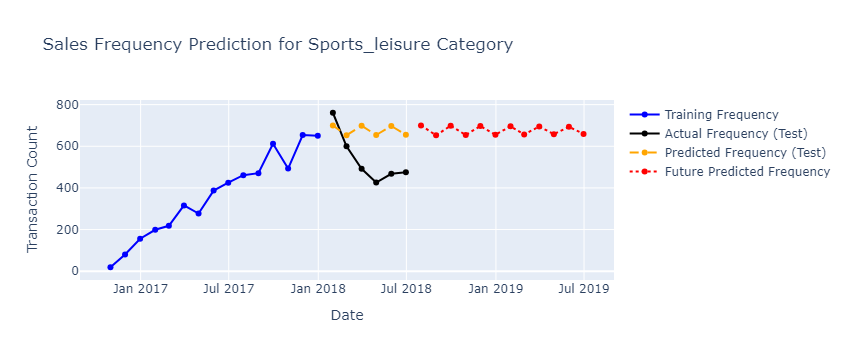

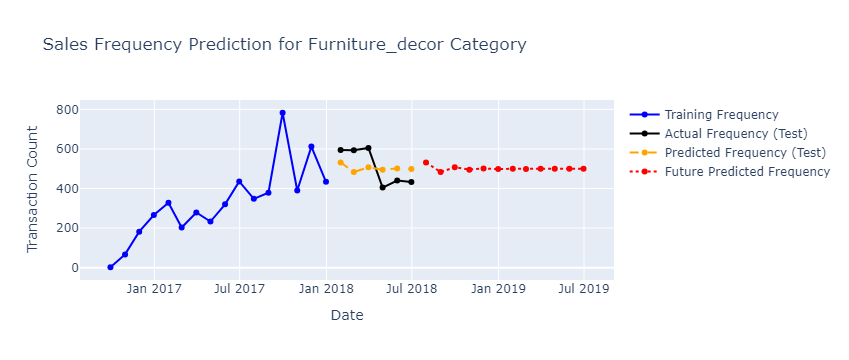

C:\Users\s\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\s\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



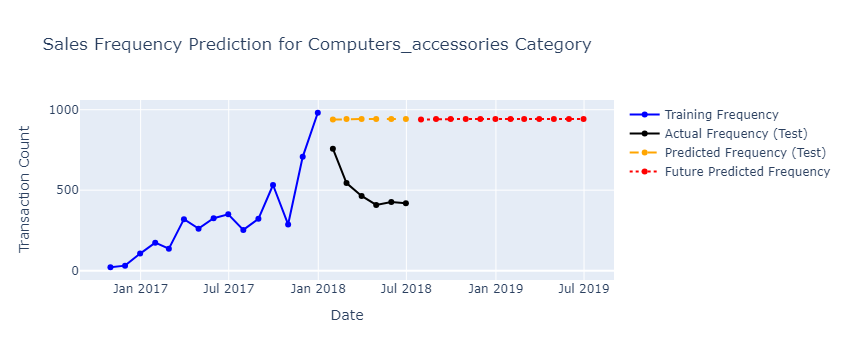

Evaluation Metrics:
                              MAE            MSE        RMSE   R² Score
bed_bath_table          64.810115    6639.744504   81.484627  -0.713826
health_beauty          102.555413   15989.660383  126.450229  -1.769345
sports_leisure         159.654116   31061.183124  176.241831  -1.417338
furniture_decor         81.443114    6998.078623   83.654519   0.069734
computers_accessories  437.848346  206964.092893  454.933064 -12.784842

The category with the highest predicted frequency is: computers_accessories with predicted frequency of 5647.09 transactions.


In [57]:
import pandas as pd
import plotly.graph_objs as go
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the cleaned dataset
full_data = pd.read_csv('cleaned_full_data.csv')

# Calculate total transactions for each product category
total_transactions_by_category = (
    full_data.groupby('product_category_name_english')['order_id']  # Assuming 'order_id' is the unique identifier for each transaction
    .count()
    .reset_index()
)

# Identify the top 5 categories by total transactions
top_categories = total_transactions_by_category.nlargest(5, 'order_id')['product_category_name_english'].tolist()

# Summary dictionary for results
results_summary = {}
predicted_sales_summary = {}

# Future months to predict
future_months = 12

# Time Series Analysis for Each Top Category
for category_name in top_categories:
    # Filter data for the category
    category_data = full_data[full_data['product_category_name_english'] == category_name]

    # Group by year and month, counting transactions
    category_monthly_sales = category_data.groupby(['order_year', 'order_month'])['order_id'].count().reset_index()

    # Create Date column and set as index
    category_monthly_sales['date'] = pd.to_datetime(
        category_monthly_sales['order_year'].astype(str) + '-' + 
        category_monthly_sales['order_month'].astype(str).str.zfill(2) + '-01'
    )
    category_monthly_sales.set_index('date', inplace=True)
    category_monthly_sales.index = pd.date_range(start=category_monthly_sales.index[0], 
                                                  periods=len(category_monthly_sales), 
                                                  freq='ME')

    # Split data for training and testing
    train_data = category_monthly_sales[category_monthly_sales.index < '2018-01-01']
    test_data = category_monthly_sales[category_monthly_sales.index >= '2018-01-01']

    try:
        # Fit the ARIMA model on transaction counts
        model = ARIMA(train_data['order_id'], order=(1, 1, 1))  # Adjust order as necessary
        model_fit = model.fit()

        # Predictions for test set
        y_pred_test = model_fit.forecast(steps=len(test_data))

        # Calculate evaluation metrics
        mae = mean_absolute_error(test_data['order_id'], y_pred_test)
        mse = mean_squared_error(test_data['order_id'], y_pred_test)
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data['order_id'], y_pred_test)

        results_summary[category_name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R² Score': r2}
        predicted_sales_summary[category_name] = {'Predicted Frequency': y_pred_test.sum()}  # Total predicted transactions

        # Future Predictions
        future_index = pd.date_range(start=category_monthly_sales.index[-1] + pd.DateOffset(months=1), 
                                      periods=future_months, freq='ME')
        future_predictions = model_fit.forecast(steps=future_months)

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=train_data.index, y=train_data['order_id'], mode='lines+markers', name='Training Frequency', line=dict(color='blue')))
        fig.add_trace(go.Scatter(x=test_data.index, y=test_data['order_id'], mode='lines+markers', name='Actual Frequency (Test)', line=dict(color='black')))
        fig.add_trace(go.Scatter(x=test_data.index, y=y_pred_test, mode='lines+markers', name='Predicted Frequency (Test)', line=dict(dash='dash', color='orange')))
        fig.add_trace(go.Scatter(x=future_index, y=future_predictions, mode='lines+markers', name='Future Predicted Frequency', line=dict(dash='dot', color='red')))
        fig.update_layout(title=f'Sales Frequency Prediction for {category_name.capitalize()} Category', 
                          xaxis_title='Date', yaxis_title='Transaction Count', hovermode="x unified")
        fig.show()

    except Exception as e:
        print(f"Error fitting model for {category_name}: {e}")

# Results Summary
results_df = pd.DataFrame(results_summary).T
predicted_sales_df = pd.DataFrame(predicted_sales_summary).T

print("Evaluation Metrics:")
print(results_df)

highest_sales_category = predicted_sales_df['Predicted Frequency'].idxmax()
highest_sales_value = predicted_sales_df['Predicted Frequency'].max()

print(f"\nThe category with the highest predicted frequency is: {highest_sales_category} "
      f"with predicted frequency of {highest_sales_value:.2f} transactions.")
